# Exercise 1: Profile a neural network for compression opportunities

Before we can compress a model effectively, we need to understand its characteristics. Think of this as a "_pre-compression checkup_"—just like a doctor examines a patient before treatment!

> **Task**: Profile a pre-trained neural network to identify potential optimization opportunities by analyzing parameter distributions, layer sizes, and inference performance.
> 
> **Goal**: By analyzing model characteristics like parameter distributions, layer sizes, and inference behavior, you'll gain insights that inform which compression techniques might be most effective.
> 
> **Tools**: pytorch, numpy, pandas, matplotlib (seaborn)
> <br> _Prior experience recommended!_
> 
> **Estimated Time**: ~=15 minutes

## Step 1: Setup

First, let's import the necessary libraries:

In [1]:
# Import libraries
import torch
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up plotting
plt.style.use('ggplot')
sns.set(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


> **Primer: Profiling tools**  
> Throughout this exercise, we'll use basic Python timing functions and PyTorch utilities. In real-world scenarios, you might use:
> - **PyTorch Profiler**: For detailed GPU kernel analysis
> - **NVIDIA Nsight**: For hardware-level GPU profiling
> - **Intel VTune**: For CPU profiling
> - **Memory_profiler**: For Python memory profiling

## Step 2: Load and analyze model parameters

We'll use [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html), a widely-used convolutional neural network for image classification.


In [2]:
# Load the model
model = models.resnet50(weights='IMAGENET1K_V1')

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model: ResNet50")
print(f"Device: {device}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/student/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s] 


Model: ResNet50
Device: cuda


## Step 3: Profile the pre-trained model

Let's profile this model from multiple angles to understand its characteristics and potential optimization opportunities.

### A. Calculate model size and parameter count

First, we need to understand the overall size of the model to determine if it's suitable for our deployment targets.

In [3]:
# TODO: Calculate total parameters in the model
# Hint: Not sure how to inspect model layers or count parameters?
# See: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# and: https://discuss.pytorch.org/t/how-do-i-count-the-number-of-parameters-in-a-model/4325
total_params = sum(p.numel() for p in model.parameters())

# TODO: Calculate trainable parameters
# Hint: Parameters have an attribute indicating if they require gradients
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# TODO: Calculate model size in MB (assuming 32-bit float - 4 bytes per parameter)
# Hint: Convert from bytes to megabytes using the appropriate divisor
model_size_mb = total_params * 4 / (1024 * 1024)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (MB): {model_size_mb:.2f}")

# Compare to common deployment constraints
print("\nDeployment Context:")
print(f"- Typical mobile app size limit: ~100MB")
print(f"- Many edge devices have <1GB of memory")
print(f"- Browser-based models often target <10MB")

Total parameters: 25,557,032
Trainable parameters: 25,557,032
Model size (MB): 97.49

Deployment Context:
- Typical mobile app size limit: ~100MB
- Many edge devices have <1GB of memory
- Browser-based models often target <10MB


> **Before you continue: Think about this!**  
> What percentage of a typical mobile app's size budget would this model consume?  
> Would this model be feasible for browser-based deployment?

### B. Analyze layer-by-layer distribution

Understanding which layers contain the most parameters helps us target optimization efforts.


In [4]:
# This function helps us extract detailed information about each layer in the model
def collect_layer_stats(model):
    stats = []
    
    for name, module in model.named_modules():
        # TODO: Define which layers to analyze
        # Hint: This is a list of layers that contain trainable parameters (weights and biases).
        # You can review which layers are in the ResNet model using `dict(model.named_modules())` and define them in this list using `torch.nn``
        # See: https://docs.pytorch.org/docs/stable/nn.html
        layer_types = [torch.nn.Conv2d, torch.nn.Linear, torch.nn.BatchNorm2d]
        if any([isinstance(module, l) for l in layer_types]):
            
            # TODO: Calculate total parameters in the module
            # Hint: You can reuse the same logic as in Step 3., except you want to consider both parameters that are trainable and not
            param_count = sum(p.numel() for p in module.parameters())
            # TODO: Calculate module size in MB (assuming 32-bit float - 4 bytes per parameter)
            # Hint: You can reuse the same logic as in Step 3.
            param_size_mb = param_count * 4 / (1024 * 1024)  # Size in MB
            
            # TODO: Extract parameter values for distribution analysis 
            # Hint: Should you select from both weight and bias?
            params = None
            if hasattr(module, 'weight') and module.weight is not None:
                params = module.weight.data.cpu().numpy().flatten()
                
            stats.append({
                'name': name,
                'type': module.__class__.__name__,
                'parameters': param_count,
                'size_mb': param_size_mb,
                'params_array': params
            })
    
    return stats

# Run the collection function
layer_stats = collect_layer_stats(model)

# Convert the stats list to a DataFrame
stats_df = pd.DataFrame(layer_stats)

# Calculate the percentage of total parameters for each layer
stats_df['parameters_pct'] = stats_df['parameters'] / total_params * 100

# Sort layers by parameter count (descending)
stats_df_sorted = stats_df.sort_values('parameters', ascending=False)

# Display top n layers by parameter count
# TODO: Decide how many layers to analyze
# Hint: This is an integer (e.g., 5, 10, 15, ...)
n = 10
print(f"Top {n} layers by parameter count:")
display(stats_df_sorted[['name', 'type', 'parameters', 'size_mb', 'parameters_pct']].head(n))

# Calculate parameters by layer type (group by)
layer_type_stats = stats_df.groupby('type').agg({
    'parameters': 'sum',
    'size_mb': 'sum'
}).reset_index()
layer_type_stats['parameters_pct'] = layer_type_stats['parameters'] / total_params * 100
layer_type_stats = layer_type_stats.sort_values('parameters', ascending=False)

print("\nParameters by layer type:")
display(layer_type_stats)

Top 10 layers by parameter count:


,name,type,parameters,size_mb,parameters_pct
102,layer4.2.conv2,Conv2d,2359296,9.000000,9.231494
88,layer4.0.conv2,Conv2d,2359296,9.000000,9.231494
96,layer4.1.conv2,Conv2d,2359296,9.000000,9.231494
92,layer4.0.downsample.0,Conv2d,2097152,8.000000,8.205773
106,fc,Linear,2049000,7.816315,8.017363
104,layer4.2.conv3,Conv2d,1048576,4.000000,4.102886
90,layer4.0.conv3,Conv2d,1048576,4.000000,4.102886
100,layer4.2.conv1,Conv2d,1048576,4.000000,4.102886
98,layer4.1.conv3,Conv2d,1048576,4.000000,4.102886
94,layer4.1.conv1,Conv2d,1048576,4.000000,4.102886



Parameters by layer type:


,type,parameters,size_mb,parameters_pct
1,Conv2d,23454912,89.473389,91.774788
2,Linear,2049000,7.816315,8.017363
0,BatchNorm2d,53120,0.202637,0.207849


> **Common pitfall**: Don't focus only on the largest layer! While large layers are obvious targets, the collective impact of many smaller layers can also be significant.

### C. Visualize parameter distribution

Visualization helps us intuitively understand model's characteristics.

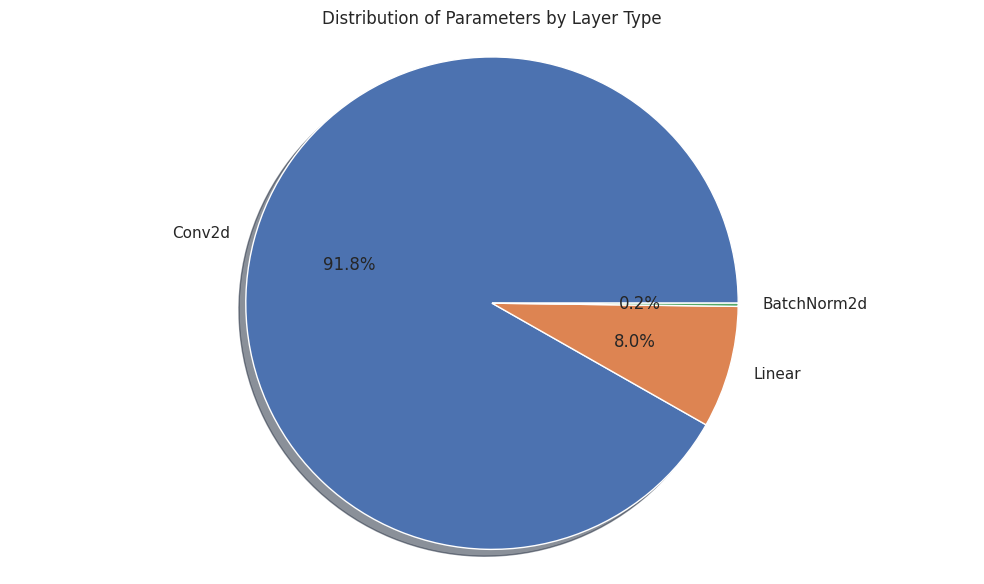

In [5]:
# Create a pie chart of parameters by layer type
plt.figure(figsize=(10, 6))
plt.pie(layer_type_stats['parameters_pct'], labels=layer_type_stats['type'], autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Parameters by Layer Type')
plt.axis('equal')
plt.tight_layout()
plt.show()

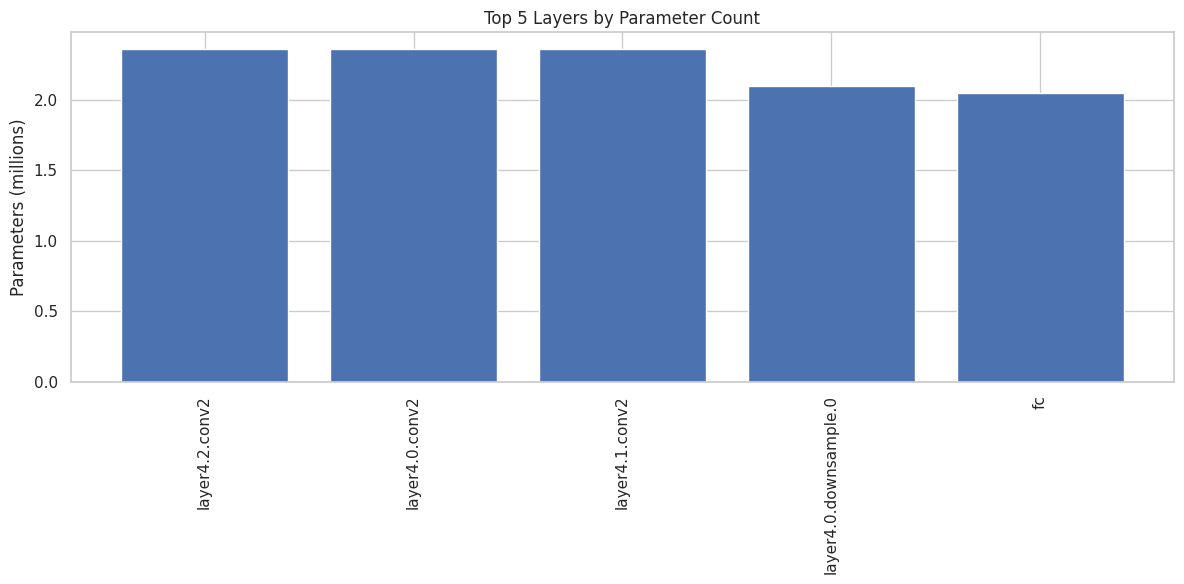

In [6]:
# TODO: Create a bar chart of top 5 layers by parameter count
# Hint: Consider dividing parameters by 1,000,000 to show values in millions - it's more readable!
plt.figure(figsize=(12, 6))
plt.bar(stats_df_sorted['name'].head(5), stats_df_sorted['parameters'].head(5) / 1_000_000)
plt.xticks(rotation=90)
plt.title('Top 5 Layers by Parameter Count')
plt.ylabel('Parameters (millions)')
plt.tight_layout()
plt.show()

> **Business impact**  
> The visualizations you've just created aren't just for technical analysis - they're powerful communication tools. When presenting to stakeholders:
> 
> - **Pie charts** help non-technical audiences quickly grasp where model complexity is concentrated
> - **Parameter distribution plots** can justify optimization decisions with clear visual evidence
> - **Latency measurements** translated to business metrics (e.g., "this allows us to serve 2x more customers") are more compelling than technical metrics alone
> 
> Always tailor your visualizations to your audience and connect them to business objectives!

### D. Analyze parameter distributions

Looking at weight distributions can reveal if a layer has many redundant (near-zero) parameters.

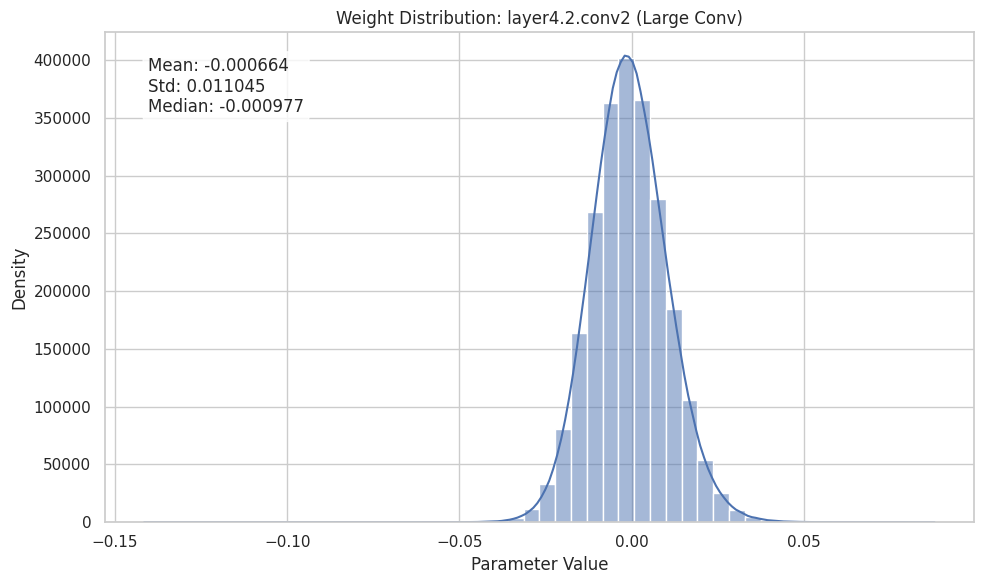

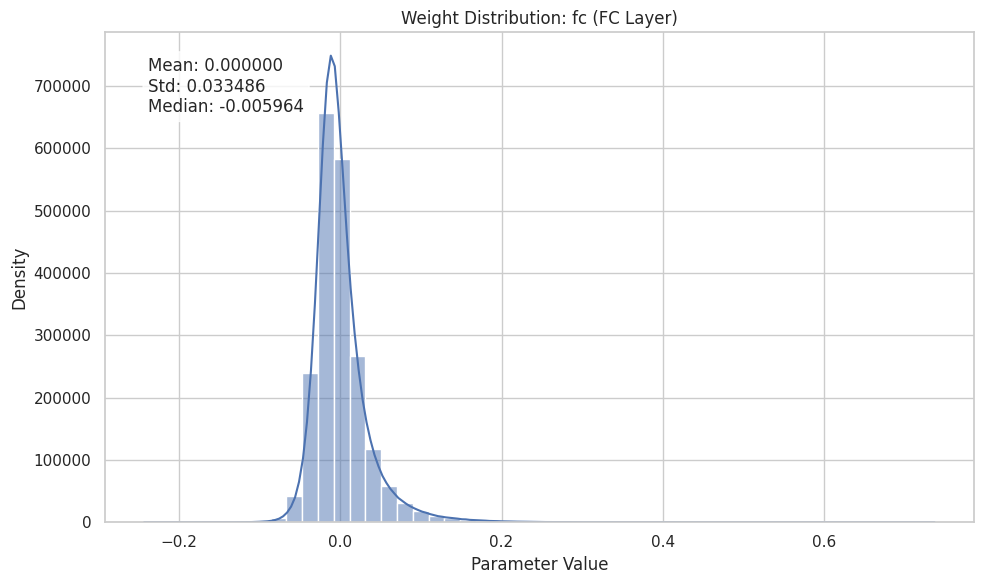

Percentage of near-zero weights in largest conv layer: 64.26%
Percentage of near-zero weights in FC layer: 30.54%


In [7]:
# This function analyzes the actual weight values to identify patterns like near-zero weights
def plot_param_distribution(params, title, bins=50):
    plt.figure(figsize=(10, 6))
    
    # Create histogram with density curve
    sns.histplot(params, bins=bins, kde=True)
    
    # Calculate statistics
    mean = np.mean(params)
    std = np.std(params)
    median = np.median(params)
    
    # Add statistics text box
    stats_text = f'Mean: {mean:.6f}\nStd: {std:.6f}\nMedian: {median:.6f}'
    plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                 va='top')
    
    plt.title(title)
    plt.xlabel('Parameter Value')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
    
    # TODO: Return percentage of weights close to zero 
    # Hint: Use 0.01 as a first threshold, but consider experimenting with others too - how does it affect the results?
    near_zero_pct = 100 * np.sum(np.abs(params) < 0.01) / len(params)
    return near_zero_pct

# Find index of the largest convolutional layer by parameter count
large_conv_layer = stats_df[stats_df['type'] == 'Conv2d'].sort_values('parameters', ascending=False).iloc[0]

# TODO: Find index of the fully connected layer (Linear)
fc_layer = stats_df[stats_df['type'] == 'Linear'].iloc[0] if 'Linear' in stats_df['type'].values else None

# Use the plot_param_distribution function to visualize these layers
# and store the percentage of near-zero weights
near_zero_large_conv = plot_param_distribution(large_conv_layer['params_array'], 
                                             f"Weight Distribution: {large_conv_layer['name']} (Large Conv)")
near_zero_fc = plot_param_distribution(fc_layer['params_array'], 
                                     f"Weight Distribution: {fc_layer['name']} (FC Layer)") if fc_layer is not None else 0

print(f"Percentage of near-zero weights in largest conv layer: {near_zero_large_conv:.2f}%")
print(f"Percentage of near-zero weights in FC layer: {near_zero_fc:.2f}%")

> **Brainstorming check!**  
> What does a high percentage of near-zero weights suggest about a layer?  
> How might this insight guide optimization approaches?

### E. Profile inference latency

Measuring inference time helps identify if the model meets real-time requirements.

In [8]:
# Helper function to measure inference time
def measure_inference_time(model, input_tensor, num_runs=50):
    # TODO: Add warmup runs
    # Hint: You can use a loop to perform a few runs (e.g., 5 or 10) without recording the timing. This can be added before you start measuring latency.
    with torch.no_grad():
        for _ in range(5):  # Warmup runs
            _ = model(input_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
    
    # Measure inference time for multiple runs
    latencies = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(input_tensor)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end_time = time.time()
            latencies.append((end_time - start_time) * 1000)  # Convert to ms
    
    # Calculate statistics
    # TODO: Choose an appropriate percentile threshold for latency analysis
    # Hint: Output is a value between 0 and 100. Common choices are P95 (95th percentile) and P99 (99th percentile)
    p_value = 95
    avg_latency = np.mean(latencies)
    p_latency = np.percentile(latencies, p_value)
    
    return avg_latency, (p_latency, p_value)


# Create input data for inference
# We need representative input data to measure realistic inference performance
batch_size = 1
input_tensor = torch.randn(batch_size, 3, 224, 224).to(device)

# TODO: Choose which device to run profiling on based on your preferred target deployment scenario (edge, cloud, ...)
# Hint: Use torch.device() with the desired hardware type
device_for_profiling = torch.device("cpu")
model_for_profiling = model.to(device_for_profiling)
input_for_profiling = input_tensor.to(device_for_profiling)

# Run the profiling
avg_latency, (p_latency, p_value) = measure_inference_time(model_for_profiling, input_for_profiling)

print(f"Average inference latency: {avg_latency:.2f} ms")
print(f"P{p_value} inference latency: {p_latency:.2f} ms")

# Context for these numbers
print("\nPerformance Context:")
print("- Human perception threshold for 'instant': ~100ms")
print("- Interactive applications typically target <50ms latency")
print("- Real-time video (30 FPS) requires processing in <33ms per frame")

Average inference latency: 540.06 ms
P95 inference latency: 597.57 ms

Performance Context:
- Human perception threshold for 'instant': ~100ms
- Interactive applications typically target <50ms latency
- Real-time video (30 FPS) requires processing in <33ms per frame


> **Profiling tip**  
> Always include warmup runs when profiling neural networks. The first few runs are often slower due to:
> - JIT compilation (especially with PyTorch)
> - GPU kernel caching
> - Memory allocations

## Step 4. Summarize profiling results

Now we bring together all our findings to identify the most promising optimization opportunities.

In [9]:
# Identify the top 3 layers by parameter count from your analysis
largest_layers = [
    stats_df_sorted.iloc[0]['name'],
    stats_df_sorted.iloc[1]['name'],
    stats_df_sorted.iloc[2]['name']
]

# TODO: Estimate the percentage of potentially redundant parameters
# Hint: Combine the near_zero_large_conv and near_zero_fc values calculated in step D
redundant_params_pct = np.mean([near_zero_large_conv, near_zero_fc])

# Summarize performance characteristics
model_summary = {
    "total_parameters": total_params,
    "model_size_mb": model_size_mb,
    "largest_layer_type": layer_type_stats.iloc[0]['type'],
    "largest_layers": largest_layers,
    "redundant_params_pct": redundant_params_pct,
    "avg_inference_latency_ms": avg_latency,
    f"p{p_value}_inference_latency_ms": p_latency,
}

# Print a formatted summary
print("="*50)
print("MODEL PROFILING SUMMARY")
print("="*50)
for key, value in model_summary.items():
    print(f"{key}: {value}")
print("="*50)

MODEL PROFILING SUMMARY
total_parameters: 25557032
model_size_mb: 97.49234008789062
largest_layer_type: Conv2d
largest_layers: ['layer4.2.conv2', 'layer4.0.conv2', 'layer4.1.conv2']
redundant_params_pct: 47.40349527994792
avg_inference_latency_ms: 540.0563144683838
p95_inference_latency_ms: 597.5690841674805


## Conclusion

In this exercise, you've learned how to:
- Analyze the parameter distribution across a neural network
- Identify which layers consume the most memory
- Examine parameter value distributions within layers
- Perform basic inference latency profiling

These skills form the foundation for effective model optimization. Before you can make a model smaller or faster, you need to understand where the size and performance bottlenecks are.